In [1]:
import cv2 # computer vision library
import helpers # helper functions

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for loading in images

%matplotlib inline


# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"


# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)


# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    standard_im = np.copy(image)
    standard_im = cv2.resize(standard_im, (32,32))
    
    return standard_im


def one_hot_encode(label):
    
#     one_hot_encoded = [] 
#     if label == "red":
#         one_hot_encoded = [1,0,0]
#     elif label == "yellow":
#         one_hot_encoded = [0,1,0]
#     elif label == "green":
#         one_hot_encoded = [0,0,1]
#     return one_hot_encoded

    # 改进1
    label_types = ['red', 'yellow', 'green']
    # Create a vector of 0's that is the length of the number of classes (3)
    one_hot_encoded = [0] * len(label_types)
    # Set the index of the class number to 1
    one_hot_encoded[label_types.index(label)] = 1 
    return one_hot_encoded

#     # 改进2
#     dic_standard={'red':[1,0,0],'yellow':[0,1,0],'green':[0,0,1]}
#     one_hot_encoded=dic_standard[label]


def standardize(image_list):
    
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, one_hot_label))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

# 版本4
- 裁剪
- 模糊
- 创建蒙版
- 判断选中区域中 各颜色像素占比


# 审阅建议

## 1.代码优化:
- one_hot_encode(label) 改进

## 2.使用亮度特征
- 利用V值和位置信息，步骤为：
  1. 将你的图片转换成hsv
  2. 保持v渠道并丢弃其他 v = hsv \[：，;，2\]
  3. 确定3个区域
    - 你可以通过somearray \[a：b，c：d\]从数组中提取一个区域。
    - 你需要选择a，b，c，d来定义红色，绿色和黄色区域）。
    - 例如redRegion = v \[4:12，12:22\]，这意味着红色区域从第4行到第12行，从第12列到第22列。数字是指示性的。
    - 最大的挑战是确定有用区域
    - 区域可以重叠
  4. 创建一个值（总和亮度，平均亮度，最大亮度，亮度+其他东西？）。您可以使用numpy.sum（数组）来对区域的所有值进行求和。在这里使用numpy的函数（numpy.sum或numpy.average）来缩短代码
  5. 根据该值进行分类（numpy的argmax功能可能也有帮助）
  6. 如果你找到了正确的区域（并通过区域面积除以标准化亮度），你可以获得高达99％的准确度
- V值，位置和mask：
  - 转换成HSV空间，分离V值
  - 裁剪图片，尽可能仅保留交通灯全部；
  - 创建蒙版，背景为黑色
  - 根据灯的相对位置关系，分成三区间，分别计算三区间累计V值；
  - 根据上述累计值比较，分别对应红，黄，绿三色
- V值和RGB
  - 进行适当的图像裁剪
  - 从RGB转换到HSV空间
  - 取最大亮度点对应的坐标
  - 最大亮度点位置对应的色调值RGB作为判断依据


# 版本5: 根据审阅修改

## 直接在原图片上取 三个灯的大致区域

### 1.通过亮度总和来判断, (由于没有蒙版,所以相当于区域内的亮度平均值)
- 当灯在原图片中的位置有较大偏移时,去除的区域包含部分背景,背景过亮导致判断错误, (主要是红\绿灯判断错误)

### 2.通过亮度最大值来判断
- 缺陷同上,且受到的影响更大
- 暂不采用

### 结果
Accuracy: 0.9629629629629629  
Number of misclassified images = 11 out of 297


In [481]:
def create_feature(rgb_image, show=0):

    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    v = hsv_image[:,:,2]
    s = hsv_image[:,:,1]
    
    # 规定区域, 由于图片中的红绿灯主体不一定在正间, 所以区域需要调整
    # 统一区域为 宽度w, 高度h的矩形 
    w = 20
    h = 8
    # 区域矩形 anchor左上角
    redAnchor = (6,4)
    yellowAnchor = (6,12)
    greenAnchor = (6,20)
    redRegion = v[redAnchor[1]:redAnchor[1]+h, redAnchor[0]:redAnchor[0]+w]
    yellowRegion = v[yellowAnchor[1]:yellowAnchor[1]+h, yellowAnchor[0]:yellowAnchor[0]+w]
    greenRegion = v[greenAnchor[1]:greenAnchor[1]+h, greenAnchor[0]:greenAnchor[0]+w]

    
    # 计算区域中的亮度 总和
    red_brightness = np.sum(redRegion)
    yellow_brightness = np.sum(yellowRegion)
    green_brightness = np.sum(greenRegion)
    
    feature = [red_brightness, yellow_brightness, green_brightness]
    predected_label = [0,0,0]
    predected_label[np.argmax(feature)] = 1
    
    
    # 测试用, 显示参数和图片
    if show == 1:
        print(feature)
        
        # 画出划定的范围
        region = rgb_image.copy()
        region = cv2.rectangle(region, redAnchor, (redAnchor[0]+w, redAnchor[1]+h), (255, 0, 0), 1)
        region = cv2.rectangle(region, yellowAnchor, (yellowAnchor[0]+w, yellowAnchor[1]+h), (255, 255,0), 1)
        region = cv2.rectangle(region, greenAnchor, (greenAnchor[0]+w, greenAnchor[1]+h), (0, 255, 0), 1)
        
        f, axs = plt.subplots(2, 4, figsize=(20,8))
        ax0 = axs[0,0]
        ax0.imshow(rgb_image)
        ax0.set_title("rgb_image")
        ax1 = axs[0,1]
        ax1.imshow(region)
        ax1.set_title("region")
        ax2 = axs[0,2]
        ax2.imshow(v, cmap='gray')
        ax2.set_title("v")
        ax3 = axs[0,3]
        ax3.bar(['r', 'y', 'g'], feature)
        ax3.set_title("sum of brightness")
        
        ax4 = axs[1,0]
        ax4.imshow(redRegion, cmap='gray')
        ax4.set_title("redRegion")
        ax5 = axs[1,1]
        ax5.imshow(yellowRegion, cmap='gray')
        ax5.set_title("yellowAnchor")
        ax6 = axs[1,2]
        ax6.imshow(greenRegion, cmap='gray')
        ax6.set_title("greenRegion")
        ax7 = axs[1,3]
        ax7.imshow(s, cmap='gray')
        ax7.set_title("s")
    
    return predected_label


[9030, 8556, 12146]
test_label [0, 0, 1]   predicted_label [0, 0, 1]


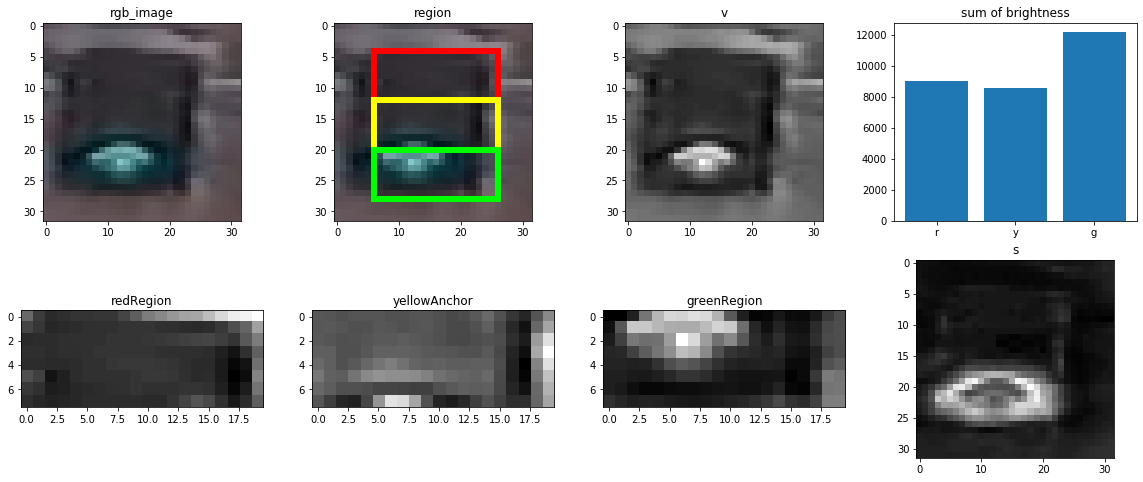

In [208]:
image_num = 879
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

predicted_label = create_feature(test_im, show=1)
print("test_label", test_label, "  predicted_label", predicted_label) 

# 版本6

## create_feature2, 建立蒙版

## 蒙版后的区域内的亮度
- 计算平均亮度(亮度总和/未被蒙住的像素数量)可能出现情况: 大部分亮度低的地方被蒙住, 但是留有的背景的亮度比较高, 计算平均亮度反而更加高
  - 解决方案: sum_pixs计算像素数量时, 如果像素数少于一定值, 则返回一个比较大的值, 可以避免噪点的干扰
  - OK
- 创建蒙版时, 由于背景亮度或者饱和度过高,导致灯被蒙住了
  - 明度(v) *0.8, 饱和度(s) *0.7 , np.sum(binary)/255 < 16
    ```
    Accuracy: 0.9696969696969697
    Number of misclassified images = 9 out of 297
    ```
  - 区域明度(v) *1.2
  ```
    Accuracy: 0.9730639730639731
    Number of misclassified images = 8 out of 297
  ```
  - 区域明度(v) *2  , 饱和度(s) *0.7(区域*0.6)
  ```
  Accuracy: 0.9764309764309764
  Number of misclassified images = 7 out of 297
  ```

In [2]:
# 裁剪图片, 裁剪为 20*24 的图像
def crop_image(image):
    row_crop = 4
    col_crop = 6
    return image[row_crop:-row_crop,col_crop:-col_crop,:]

In [3]:
# blur
# http://setosa.io/ev/image-kernels/
def blur(image):
    blur_kernel = np.array([[ 0.0625, 0.125, 0.0625], 
                   [ 0.125, 0.25, 0.125], 
                   [ 0.0625, 0.125, 0.0625]])
    blur_image = cv2.filter2D(image, -1, blur_kernel)
    # plt.imshow(blur_image)
    # plt.title("blur_image")
    # plt.show()
    return blur_image

In [635]:
# 创建蒙版 明度(v) *0.8
# def create_v_mask(rgb_image):
#     hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
#     sum_brightness = np.sum(hsv_image[:,:,2])
#     area = 32*32
#     v = int(sum_brightness/area * 0.8)
    
#     v_lower = np.array([0,0,0])
#     v_upper = np.array([179,255,v])
#     v_mask = cv2.inRange(hsv_image, v_lower, v_upper)
#     return v_mask


def create_v_mask(rgb_image):
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    sum_brightness = np.sum(hsv_image[4:-4,6:-6,1])
    area = 32*32
    v = int(sum_brightness/area * 2)
    
    v_lower = np.array([0,0,0])
    v_upper = np.array([179,255,v])
    v_mask = cv2.inRange(hsv_image, v_lower, v_upper)
    return v_mask

In [682]:
# 创建蒙版 饱和度(s) *0.7

def create_s_mask(rgb_image):
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    sum_s = np.sum(hsv_image[:,:,1])
    area = 32*32
    s = int(sum_s/area * 0.7)
    
    s_lower = np.array([0,0,0])
    s_upper = np.array([179,s,255])
    s_mask = cv2.inRange(hsv_image, s_lower, s_upper)
    return s_mask

# def create_s_mask(rgb_image):
#     hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
#     sum_s = np.sum(hsv_image[4:-4,6:-6,1])
#     area = 24*20
#     s = int(sum_s/area * 0.6)
    
#     s_lower = np.array([0,0,0])
#     s_upper = np.array([179,s,255])
#     s_mask = cv2.inRange(hsv_image, s_lower, s_upper)
#     return s_mask

In [523]:
def create_mask(rgb_image):
    v_mask = create_v_mask(rgb_image)
    s_mask = create_s_mask(rgb_image)
    mask = cv2.bitwise_or(v_mask, s_mask)

    # 膨胀操作
    kernel = np.ones((2, 2), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
#     # 腐蚀操作
#     kernel = np.ones((2, 2), np.uint8)
#     mask = cv2.erode(mask, kernel, iterations=1)
    return mask

In [609]:
# 计算区域内未被遮盖的像素数
def sum_pixs(region):
    # 二值化
    ret, binary = cv2.threshold(region, 1, 255, cv2.THRESH_BINARY)
    
    
    if np.sum(binary)/255 == 0:
        return 20*8
    elif np.sum(binary)/255 < 16:  # 避免噪点, 导致亮度平均值过高
        return 20*8
    else:
        return np.sum(binary)/255


In [672]:
def create_feature2(rgb_image, show=0):
    
    blur_image = blur(rgb_image)
    mask = create_mask(blur_image)

#     mask = create_mask(rgb_image)
    
    # 遮盖图像
    masked_image = np.copy(rgb_image)
    masked_image[mask != 0] = [0, 0, 0]
    
    hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_RGB2HSV)

    v = hsv_image[:,:,2]
    
    # 规定区域, 由于图片中的红绿灯主体不一定在正间, 所以区域需要调整
    # 统一区域为 宽度w, 高度h的矩形 
    w = 20
    h = 8
    # anchor左上角
    redAnchor = (6,4)
    yellowAnchor = (6,12)
    greenAnchor = (6,20)
    redRegion = v[redAnchor[1]:redAnchor[1]+h, redAnchor[0]:redAnchor[0]+w]
    yellowRegion = v[yellowAnchor[1]:yellowAnchor[1]+h, yellowAnchor[0]:yellowAnchor[0]+w]
    greenRegion = v[greenAnchor[1]:greenAnchor[1]+h, greenAnchor[0]:greenAnchor[0]+w]

    
    # 计算区域中的亮度 总和 feature1
    red_brightness = np.sum(redRegion)
    yellow_brightness = np.sum(yellowRegion)
    green_brightness = np.sum(greenRegion)
    
    feature = [red_brightness, yellow_brightness, green_brightness]
    predected_label = [0,0,0]
    predected_label[np.argmax(feature)] = 1
    
    
    # 计算区域中的亮度 总和/像素数 feature2
    red_brightness_avg = np.sum(redRegion) / sum_pixs(redRegion)
    yellow_brightness_avg = np.sum(yellowRegion) / sum_pixs(yellowRegion)
    green_brightness_avg = np.sum(greenRegion) / sum_pixs(greenRegion)
    
    feature2 = [red_brightness_avg, yellow_brightness_avg, green_brightness_avg]
    predected_label2 = [0,0,0]
    predected_label2[np.argmax(feature2)] = 1

    # 测试用, 显示参数和图片
    if show == 1:
        print("feature", feature)
        print("feature2",feature2)
        print("sum_pixs",[sum_pixs(redRegion),sum_pixs(yellowRegion),sum_pixs(greenRegion)])
        
        # 画出划定的范围, 注意画图坐标和切片不一样
        region = rgb_image.copy()
        region = cv2.rectangle(region, redAnchor, (redAnchor[0]+w, redAnchor[1]+h), (255, 0, 0), 1)
        region = cv2.rectangle(region, yellowAnchor, (yellowAnchor[0]+w, yellowAnchor[1]+h), (255, 255,0), 1)
        region = cv2.rectangle(region, greenAnchor, (greenAnchor[0]+w, greenAnchor[1]+h), (0, 255, 0), 1)
        
        f, axs = plt.subplots(2, 4, figsize=(20,8))
        ax0 = axs[0,0]
        ax0.imshow(rgb_image)
        ax0.set_title("rgb_image")
        ax1 = axs[0,1]
        ax1.imshow(region)
        ax1.set_title("region")
        ax2 = axs[0,2]
        ax2.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)[:,:,2], cmap='gray')
        ax2.set_title("masked_v")
        ax3 = axs[0,3]
        ax3.bar(['r', 'y', 'g'], feature)
        ax3.set_title("sum of brightness")
        
        ax4 = axs[1,0]
        ax4.imshow(redRegion, cmap='gray')
        ax4.set_title("redRegion")
        ax5 = axs[1,1]
        ax5.imshow(yellowRegion, cmap='gray')
        ax5.set_title("yellowAnchor")
        ax6 = axs[1,2]
        ax6.imshow(greenRegion, cmap='gray')
        ax6.set_title("greenRegion")
        ax7 = axs[1,3]
        ax7.bar(['r', 'y', 'g'], feature2)
        ax7.set_title("avg of brightness")
    
    
    return predected_label2


[8882, 6699, 11968]
[2220.5, 181.05405405405406, 2992.0]
test_label [0, 0, 1]   predicted_label [0, 0, 1]


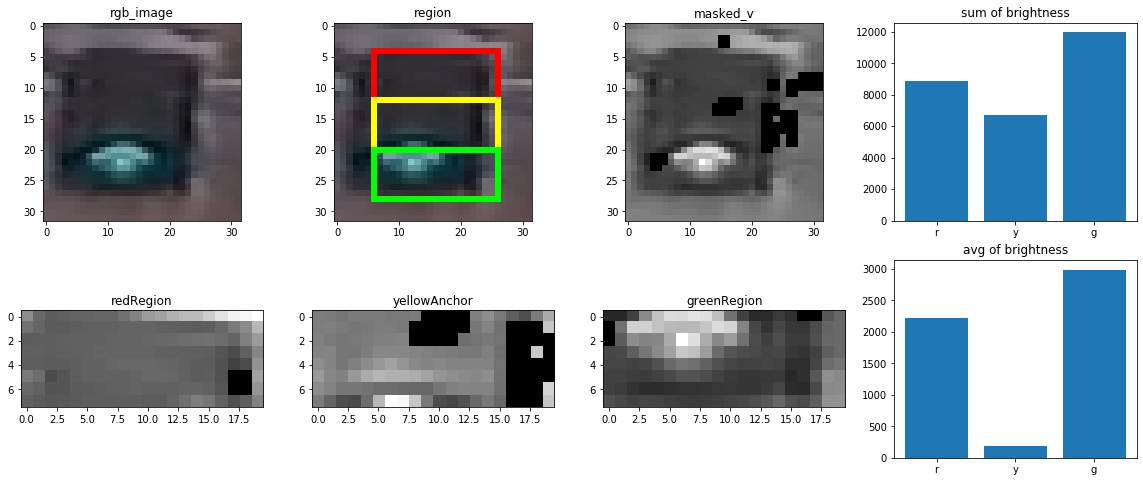

In [288]:
image_num = 879
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

predicted_label = create_feature2(test_im, show=1)
print("test_label", test_label, "  predicted_label", predicted_label) 

In [292]:
def estimate_label(rgb_image):
    
    ## TODO: Extract feature(s) from the RGB image and use those features to
    ## classify the image and output a one-hot encoded label
    predicted_label = create_feature2(rgb_image)
    
    return predicted_label 


In [120]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [684]:
# Constructs a list of misclassified images given a list of test images and their labels
# This will throw an AssertionError if labels are not standardized (one-hot encoded)

def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


Accuracy: 0.9764309764309764
Number of misclassified images = 7 out of 297


In [685]:
# Importing the tests
import test_functions
tests = test_functions.Tests()

if(len(MISCLASSIFIED) > 0):
    # Test code for one_hot_encode function
    tests.test_red_as_green(MISCLASSIFIED)
else:
    print("MISCLASSIFIED may not have been populated with images.")


**<span style="color: green;">TEST PASSED</span>**

0 predicted_label [1, 0, 0] true_label [0, 0, 1]
1 predicted_label [1, 0, 0] true_label [0, 0, 1]
2 predicted_label [0, 1, 0] true_label [1, 0, 0]
3 predicted_label [0, 1, 0] true_label [1, 0, 0]
4 predicted_label [1, 0, 0] true_label [0, 0, 1]
5 predicted_label [1, 0, 0] true_label [0, 0, 1]
6 predicted_label [0, 0, 1] true_label [0, 1, 0]


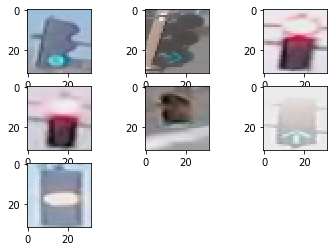

In [686]:
for i in range(len(MISCLASSIFIED)):
    print(i, "predicted_label", MISCLASSIFIED[i][1], "true_label", MISCLASSIFIED[i][2])
for i in range(7):
    plt.subplot(331+i)
    plt.imshow(MISCLASSIFIED[i][0])

feature [8790, 4011, 6899]
feature2 [108.51851851851852, 100.275, 98.55714285714286]
[81.0, 40.0, 70.0]


[1, 0, 0]

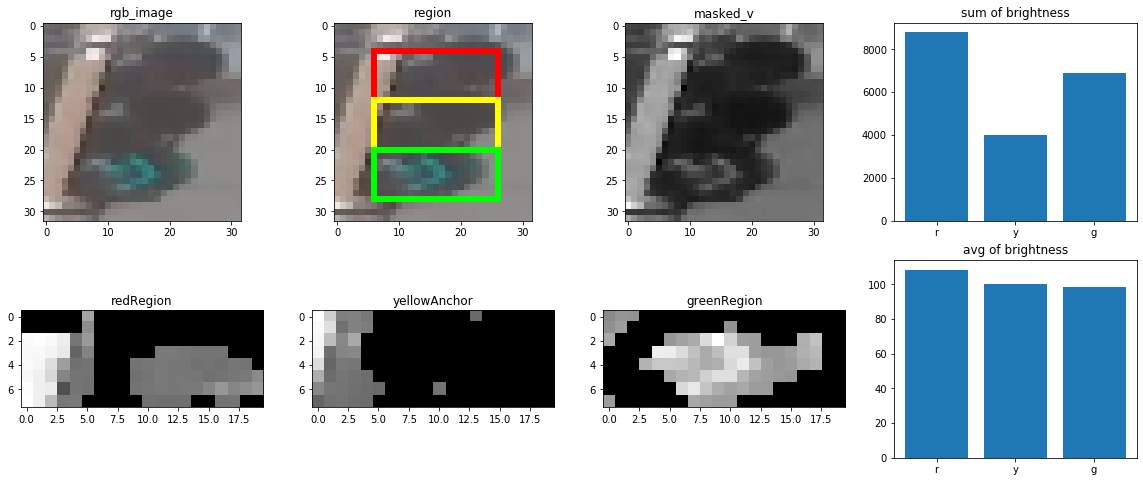

In [676]:
i = 1
create_feature2(MISCLASSIFIED[i][0], show=1)

[16776, 14091, 16114]


[1, 0, 0]

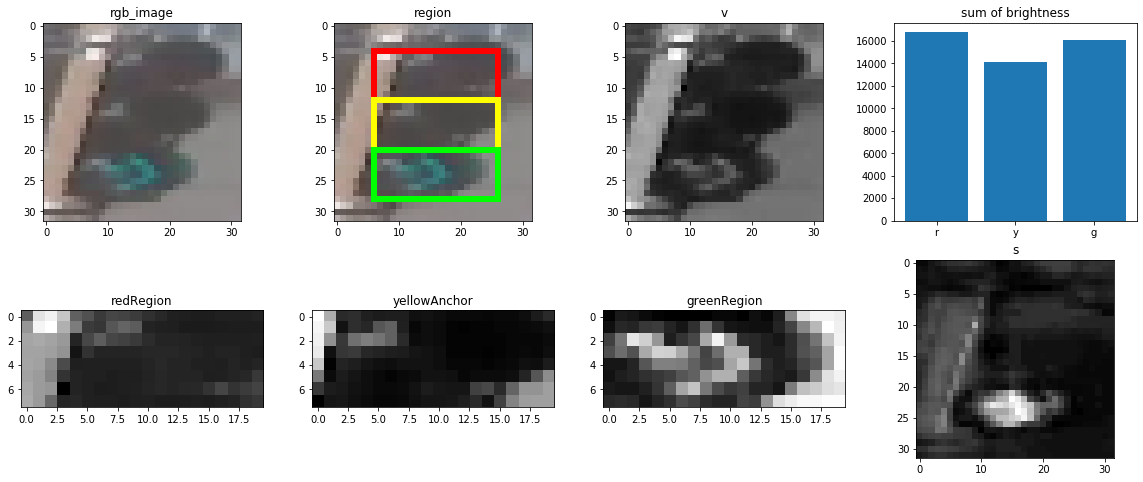

In [677]:
create_feature(MISCLASSIFIED[i][0], show=1)